In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/My Drive/loans.csv")

Data description:
       credit.policy     int.rate  ...      pub.rec  not.fully.paid
count    9578.000000  9578.000000  ...  9549.000000     9578.000000
mean        0.804970     0.122640  ...     0.062101        0.160054
std         0.396245     0.026847  ...     0.262152        0.366676
min         0.000000     0.060000  ...     0.000000        0.000000
25%         1.000000     0.103900  ...     0.000000        0.000000
50%         1.000000     0.122100  ...     0.000000        0.000000
75%         1.000000     0.140700  ...     0.000000        0.000000
max         1.000000     0.216400  ...     5.000000        1.000000

[8 rows x 13 columns]
Data head:
   credit.policy             purpose  ...  pub.rec  not.fully.paid
0              1  debt_consolidation  ...      0.0               0
1              1         credit_card  ...      0.0               0
2              1  debt_consolidation  ...      0.0               0
3              1  debt_consolidation  ...      0.0               0
4

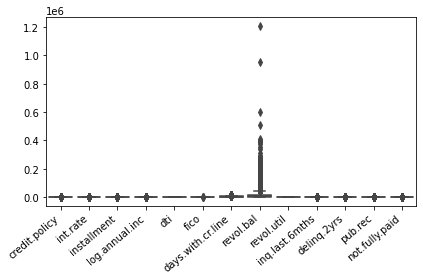

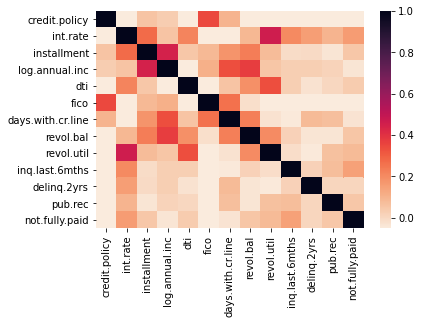

In [4]:
print("Data description:")
print(df.describe())
print("Data head:")
print(df.head(5))
print("Column types:")
print(df.dtypes)
print("Null values in the dataset:")
print(df.isnull().sum())

''' individual column value distribution '''
ax=sns.boxplot(data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()
cmap = sns.cm.rocket_r

''' correlation map '''
ax = sns.heatmap(df.corr(),annot=False,fmt=".3f",vmin=-0.05,cmap = cmap)


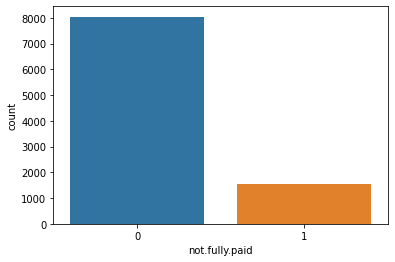

In [5]:
''' Paid and not paid distribution '''
sns.countplot(x='not.fully.paid',data=df)

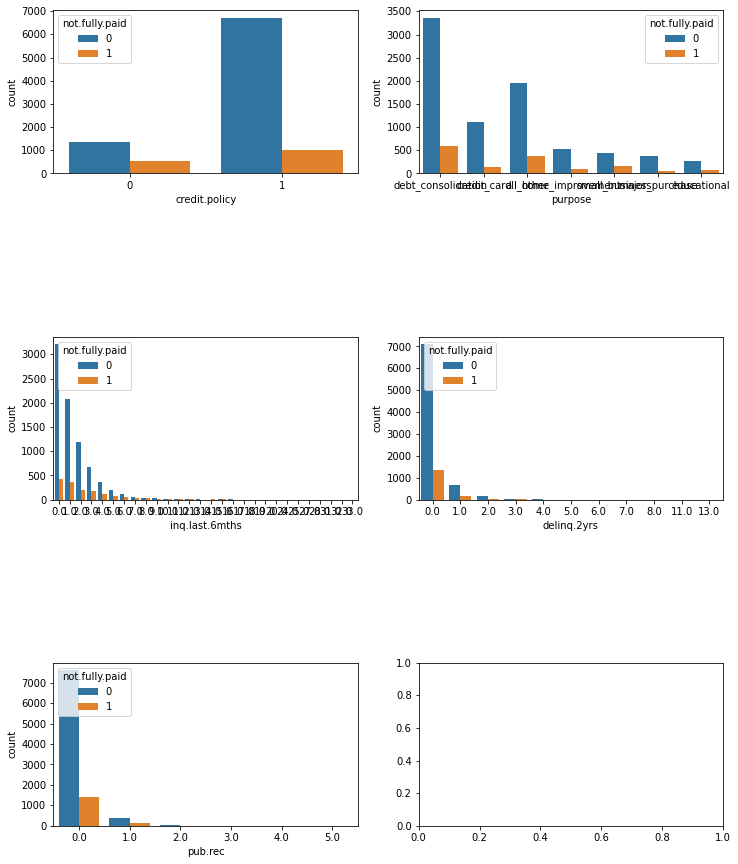

In [6]:
''' not.fully.paid status with respect to categorical data in the dataset '''

categorical_columns = ['credit.policy', 'purpose', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec']
fig,axes = plt.subplots(3,2,figsize=(12,15))
for idx,cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=df,hue='not.fully.paid',ax=axes[row,col])
plt.subplots_adjust(hspace=1)

          int.rate  installment  ...     revol.bal   revol.util
count  9578.000000  9578.000000  ...  9.578000e+03  9516.000000
mean      0.122640   319.089413  ...  1.691396e+04    46.865677
std       0.026847   207.071301  ...  3.375619e+04    29.018642
min       0.060000    15.670000  ...  0.000000e+00     0.000000
25%       0.103900   163.770000  ...  3.187000e+03    22.700000
50%       0.122100   268.950000  ...  8.596000e+03    46.400000
75%       0.140700   432.762500  ...  1.824950e+04    71.000000
max       0.216400   940.140000  ...  1.207359e+06   119.000000

[8 rows x 8 columns]


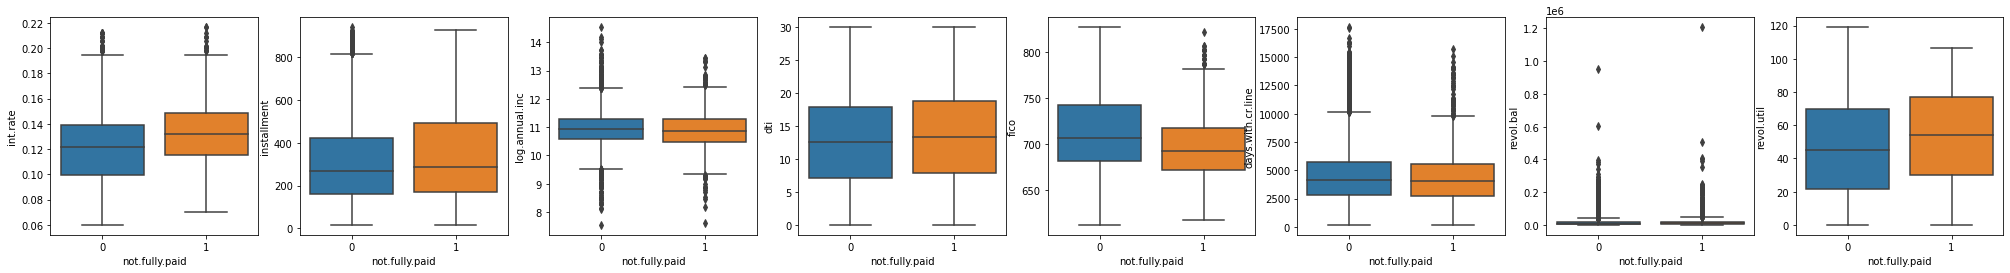

In [7]:
numerical_columns = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util']
fig,axes = plt.subplots(1,8,figsize=(35,4))
for idx,cat_col in enumerate(numerical_columns):
    sns.boxplot(y=cat_col,data=df,x='not.fully.paid',ax=axes[idx])

print(df[numerical_columns].describe())
plt.subplots_adjust(hspace=3)

Pre Processing

In [8]:
lb=LabelEncoder()
df["purpose"]=lb.fit_transform(df["purpose"])
df["credit.policy"]=lb.fit_transform(df["credit.policy"])
df["pub.rec"]=lb.fit_transform(df["pub.rec"])
df["inq.last.6mths"]=lb.fit_transform(df["inq.last.6mths"])
df["delinq.2yrs"]=lb.fit_transform(df["delinq.2yrs"])

Removing Outliers

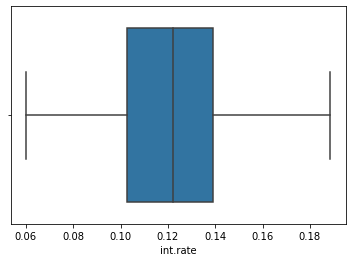

In [9]:
df = df[df['int.rate'] < 0.19] 
sns.boxplot(x=df['int.rate'])

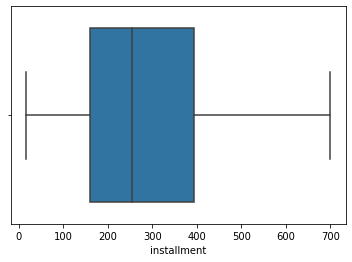

In [10]:
df = df[df['installment'] < 700] 
sns.boxplot(x=df['installment'])

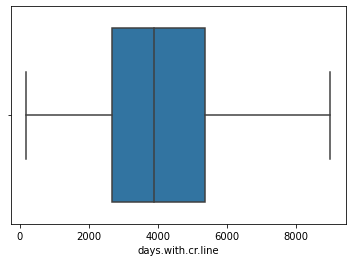

In [11]:
df = df[df['days.with.cr.line'] < 9000] 
sns.boxplot(x=df['days.with.cr.line'])

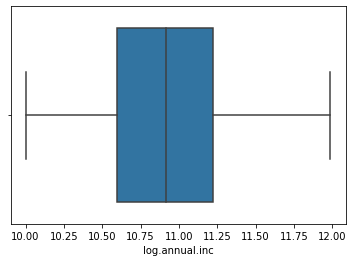

In [12]:
df = df[df['log.annual.inc'] < 12] 
df = df[df['log.annual.inc'] > 10] 
sns.boxplot(x=df['log.annual.inc'])

Balancing data

In [13]:

from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['not.fully.paid']==0]
df_minority = df[df['not.fully.paid']==1]
print(df_majority.shape)
print(df_minority.shape)
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=6494,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
print("New counts")
print(df_upsampled['not.fully.paid'].value_counts())
df=df_upsampled
#df.value_counts()

(6494, 14)
(1141, 14)
New counts
1    6494
0    6494
Name: not.fully.paid, dtype: int64


Handling missing values

In [14]:
df['purpose'] = df['purpose'].fillna(df['purpose'].mode()[0])
df['credit.policy'] =df['credit.policy'].fillna(df['credit.policy'].mode()[0])
df['pub.rec'] = df['pub.rec'].fillna(df['pub.rec'].mode()[0])
df['days.with.cr.line'] = df['days.with.cr.line'].fillna(df['days.with.cr.line'].mean())
df['revol.bal'] = df['revol.bal'].fillna(df['revol.bal'].mean())
df['revol.util'] = df['revol.util'].fillna(df['revol.util'].mean())
df['log.annual.inc'] = df['log.annual.inc'].fillna(df['log.annual.inc'].mean())
df['inq.last.6mths'] = df['inq.last.6mths'].fillna(df['inq.last.6mths'].mode()[0])
df['delinq.2yrs'] = df['delinq.2yrs'].fillna(df['delinq.2yrs'].mode()[0])
df['dti'] = df['dti'].fillna(df['dti'].mean())
df.isnull().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

Scaling data

In [15]:
df=(df-df.min())/(df.max()-df.min())
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
1,1.0,0.166667,0.366252,0.310638,0.544025,0.477129,0.441860,0.292515,0.121422,0.644538,0.000000,0.0,0.0,0.0
2,1.0,0.333333,0.588647,0.513334,0.186964,0.388314,0.325581,0.513606,0.012679,0.215126,0.037037,0.0,0.0,0.0
3,1.0,0.333333,0.317263,0.214319,0.679193,0.270451,0.465116,0.285708,0.121581,0.615126,0.037037,0.0,0.0,0.0
4,1.0,0.166667,0.642302,0.127445,0.653660,0.499833,0.255814,0.440589,0.017117,0.331933,0.000000,0.1,0.0,0.0
5,1.0,0.166667,0.146190,0.159917,0.958614,0.566945,0.534884,0.673476,0.183478,0.428571,0.000000,0.0,0.0,0.0


In [16]:
X = df.iloc[:,0:13]  
y = df.iloc[:,-1]  
print(X.head())
print("Samples: ",X.shape[0])
print("Features: ",X.shape[1])

   credit.policy   purpose  int.rate  ...  inq.last.6mths  delinq.2yrs  pub.rec
1            1.0  0.166667  0.366252  ...        0.000000          0.0      0.0
2            1.0  0.333333  0.588647  ...        0.037037          0.0      0.0
3            1.0  0.333333  0.317263  ...        0.037037          0.0      0.0
4            1.0  0.166667  0.642302  ...        0.000000          0.1      0.0
5            1.0  0.166667  0.146190  ...        0.000000          0.0      0.0

[5 rows x 13 columns]
Samples:  12988
Features:  13


Feature Importance

[0.03338584 0.06650555 0.11024509 0.09759363 0.09684438 0.0922604
 0.10090476 0.09397757 0.0900846  0.10037644 0.0743358  0.02782096
 0.01566499]


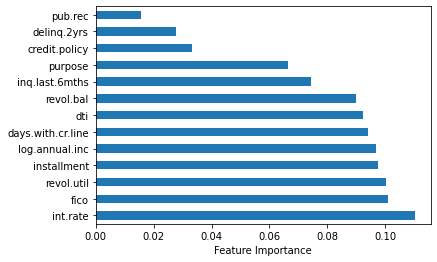

In [17]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(13).plot(kind='barh')
plt.xlabel("Feature Importance")
plt.show()

Grid Search

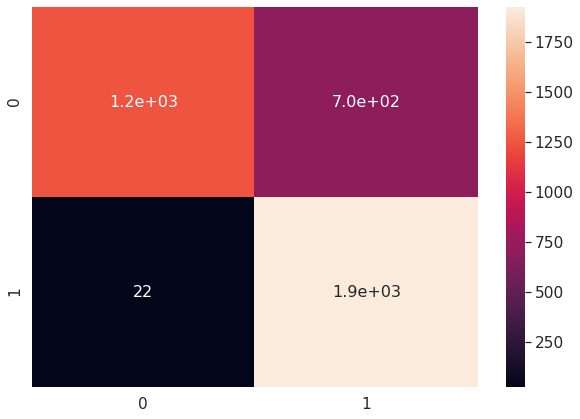

0.9795081581684201
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='distance')


In [22]:
params = {'n_neighbors': [3, 5, 7, 9, 11],'weights':['uniform','distance'],'metric':['euclidean','manhattan']}
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
model=KNeighborsClassifier()
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.30,random_state=42,stratify=y)
grid = GridSearchCV(estimator=model,param_grid=params, cv=5 ,scoring = 'roc_auc') # Turn on cv train scores
grid.fit(Xtrain, ytrain)
y_pred=grid.predict(Xtest)
array=confusion_matrix(ytest, y_pred)
df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
print(grid.best_score_)
print(grid.best_estimator_)


In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.30,random_state=42,stratify=y)
grid = GridSearchCV(estimator=model,param_grid=params, cv=5 ,scoring = 'roc_auc') # Turn on cv train scores
grid.fit(Xtrain, ytrain)
y_pred=grid.predict(Xtest)
array=confusion_matrix(ytest, y_pred)
df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
print(grid.best_score_)
print(grid.best_estimator_)

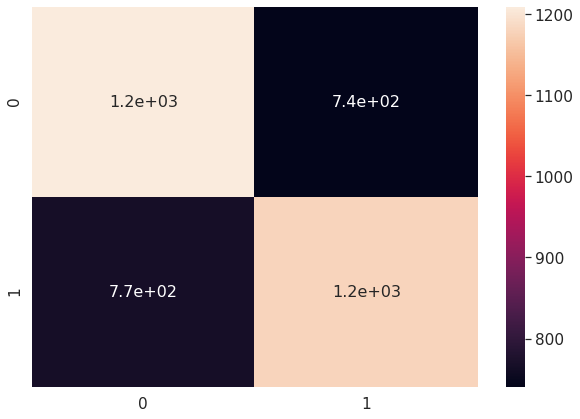

0.6714553199054718
LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
clf = LogisticRegression()
grid_values = {'penalty': ['l2'],'C':[0.1,0.25,0.5,0.9,1,5,10,15],'max_iter':[100,200,300,400]}
grid = GridSearchCV(clf, param_grid = grid_values,scoring = 'roc_auc')
grid.fit(Xtrain, ytrain)
from sklearn.metrics import confusion_matrix
y_pred=grid.predict(Xtest)
array=confusion_matrix(ytest, y_pred)
df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
print(grid.best_score_)
print(grid.best_estimator_)

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
from xgboost import XGBClassifier
#from sklearn.ensemble import GradientBoostingClassifier
model=XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.30,random_state=42,stratify=y)
grid = GridSearchCV(estimator=model,param_grid=params, cv=5 ,scoring = 'roc_auc') # Turn on cv train scores
grid.fit(Xtrain, ytrain)
y_pred=grid.predict(Xtest)
array=confusion_matrix(ytest, y_pred)
df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
print(grid.best_score_)
print(grid.best_estimator_)

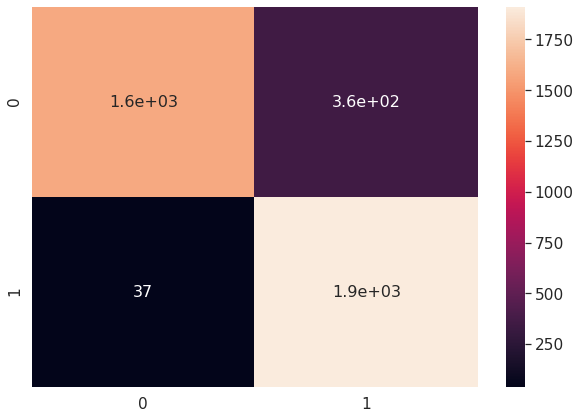

0.884052273359204
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated

In [29]:
param_grid = {"learning_rate": [0.5,0.6,0.9,1],
              "n_estimators": [1, 2]
             }
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.30,random_state=42,stratify=y)
DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)
ABC = AdaBoostClassifier(base_estimator = DTC)
# run grid search
grid_search = GridSearchCV(ABC, param_grid=param_grid, scoring = 'roc_auc')
grid_search.fit(Xtrain, ytrain)
y_pred=grid_search.predict(Xtest)
array=confusion_matrix(ytest, y_pred)
df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
print(grid_search.best_score_)
print(grid_search.best_estimator_)

0.8766804482646066
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=150, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


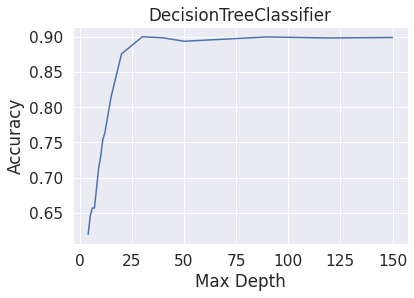

In [31]:
params={'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
model=DecisionTreeClassifier()
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.30,random_state=42,stratify=y)
grid = GridSearchCV(estimator=model,param_grid=params, cv=5 ,scoring = 'roc_auc') # Turn on cv train scores
grid.fit(Xtrain, ytrain)
print(grid.best_score_)
print(grid.best_estimator_)
arr=[]
for i in [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]:
  #model=DecisionTreeClassifier(max_depth=i)
  model = DecisionTreeClassifier(max_depth=i).fit(Xtrain, ytrain)
  ypred = model.predict(Xtest)
  acc=accuracy_score(ytest, ypred)
  arr.append(acc)
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("DecisionTreeClassifier")
plt.plot([4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150], arr)

SVM

In [33]:
#Import svm model
def show_metrics(y_true, y_score):
    # True positive
    tp = np.sum(y_true * y_score)
    # False positive
    fp = np.sum((y_true == 0) * y_score)
    # True negative
    tn = np.sum((y_true==0) * (y_score==0))
    # False negative
    fn = np.sum(y_true * (y_score==0))

    # True positive rate (sensitivity or recall)
    tpr = tp / (tp + fn)
    # False positive rate (fall-out)
    fpr = fp / (fp + tn)
    # Precision
    precision = tp / (tp + fp)
    # True negatvie tate (specificity)
    tnr = 1 - fpr
    # F1 score
    f1 = 2*tp / (2*tp + fp + fn)
    # ROC-AUC for binary classification
    auc = (tpr+tnr) / 2
    # MCC
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    print("True positive rate (recall): ", tpr)
    print("False positive rate: ", fpr)
    print("Precision: ", precision)
    print("True negative rate: ", tnr)
    print("F1: ", f1)
    print("ROC-AUC: ", auc)
    print("MCC: ", mcc)
from sklearn import svm
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.30,random_state=42,stratify=y)
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(Xtrain, ytrain)

#Predict the response for test dataset
y_pred = clf.predict(Xtest)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
show_metrics(ytest, (y_pred > 0.5).astype(np.int))

Accuracy: 0.6096997690531177
True positive rate (recall):  0.5908624229979466
False positive rate:  0.37147255002565416
Precision:  0.6138666666666667
True negative rate:  0.6285274499743458
F1:  0.6021449123724824
ROC-AUC:  0.6096949364861461
MCC:  0.21954611724901202


/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


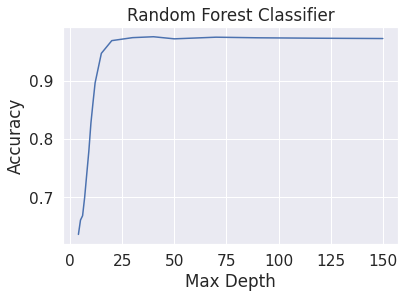

In [34]:
arr=[]
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
for i in [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]:
  #model=DecisionTreeClassifier(max_depth=i)
  model = RandomForestClassifier(max_depth=i).fit(Xtrain, ytrain)
  ypred = model.predict(Xtest)
  acc=accuracy_score(ytest, ypred)
  arr.append(acc)
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Random Forest Classifier")
plt.plot([4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150], arr)

Feature Importance for random forest

[0.01909206 0.04147181 0.12212472 0.11053803 0.10600213 0.10968025
 0.08560675 0.11320615 0.10823162 0.10829037 0.05464059 0.01305811
 0.00805743]


<BarContainer object of 13 artists>

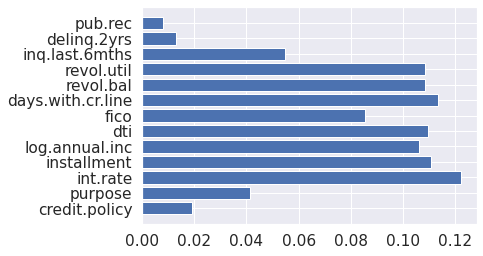

In [35]:
model = RandomForestClassifier(max_depth=i).fit(Xtrain, ytrain)
print(model.feature_importances_)
plt.barh(['credit.policy','purpose',	'int.rate'	,'installment'	,'log.annual.inc'	,'dti'	,'fico',	'days.with.cr.line'	,'revol.bal'	,'revol.util'	,'inq.last.6mths'	,'delinq.2yrs'	,'pub.rec'], model.feature_importances_)

Decision Tree Split visualisation

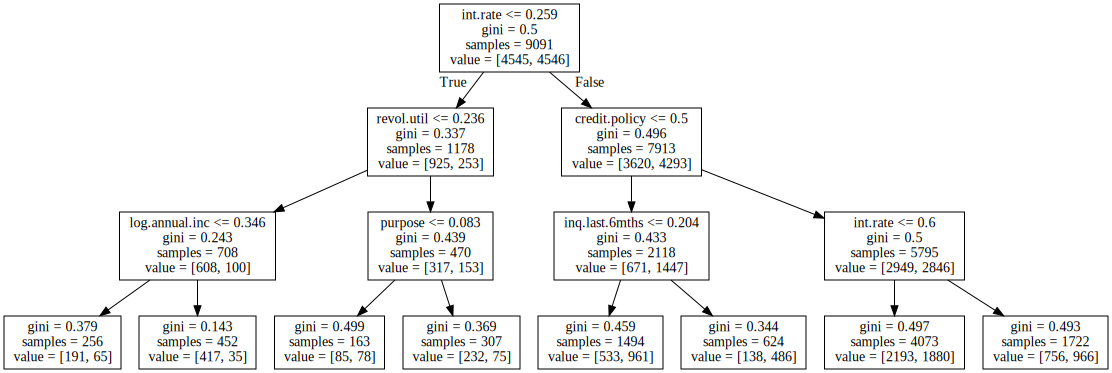

In [36]:
import graphviz 
from sklearn import tree
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.30,random_state=42,stratify=y)
tree_clf = tree.DecisionTreeClassifier(max_depth = 3)
tree_clf.fit(Xtrain,ytrain)
dot_data = tree.export_graphviz(tree_clf,feature_names = ['credit.policy','purpose',	'int.rate'	,'installment'	,'log.annual.inc'	,'dti'	,'fico',	'days.with.cr.line'	,'revol.bal'	,'revol.util'	,'inq.last.6mths'	,'delinq.2yrs'	,'pub.rec'])
graph = graphviz.Source(dot_data)
graph

Machine Learning Algorithms

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Precision:  0.5695387349184995
Train F1 Score:  0.6139722346618899
Train Accuracy:  0.6207237927620723
Test F1 Score:  0.6104936676143706
Test Accuracy:  0.6132922761098281
Validation F1 Score:  0.6167938735459517


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Validation Accuracy:  0.6169843922270182
Confusion Matrix
[[1209  740]
 [ 767 1181]]
GaussianNB(priors=None, var_smoothing=1e-09)
Precision:  0.5708412515808043
Train F1 Score:  0.5588787385809036
Train Accuracy:  0.6122538774612254
Test F1 Score:  0.5637043428242738
Test Accuracy:  0.6107261996407493
Validation F1 Score:  0.6024904521971164


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Validation Accuracy:  0.6086249471566177
Confusion Matrix
[[1400  549]
 [ 968  980]]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='distance')
Precision:  0.7215282479157824
Train F1 Score:  1.0
Train Accuracy:  1.0
Test F1 Score:  0.8359375
Test Accuracy:  0.8060046189376443
Validation F1 Score:  0.7908029110273577


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Validation Accuracy:  0.7978211894856335
Confusion Matrix
[[1215  734]
 [  22 1926]]
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Precision:  0.8409669318204199
Train F1 Score:  1.0
Train Accuracy:  1.0
Test F1 Score:  0.9099976252671574
Test Accuracy:  0.9027457018219143
Validation F1 Score:  0.8754297783352036


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Validation Accuracy:  0.8757016603254607
Confusion Matrix
[[1602  347]
 [  32 1916]]
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)
Precision:  0.9568262979660287
Train F1 Score:  1.0
Train Accuracy:  1.0
Test F1 Score:  0.9735368956743004
Test Accuracy:  0.9733128047215807
Validation F1 Score:  0.9527978224429685


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Validation Accuracy:  0.952811388890401
Confusion Matrix
[[1880   69]
 [  35 1913]]
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)
Precision:  0.6335858049644794
Train F1 Score:  0.7431153184165232
Train Accuracy:  0.7373226267737323
Test F1 Score:  0.7043586550435865
Test Accuracy:  0.695406723120349
Validation F1 Score:  0.6899538213756532


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Validation Accuracy:  0.6901342085830352
Confusion Matrix
[[1296  653]
 [ 534 1414]]
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
         

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Validation Accuracy:  0.8783419243518635
Confusion Matrix
[[1587  362]
 [  24 1924]]


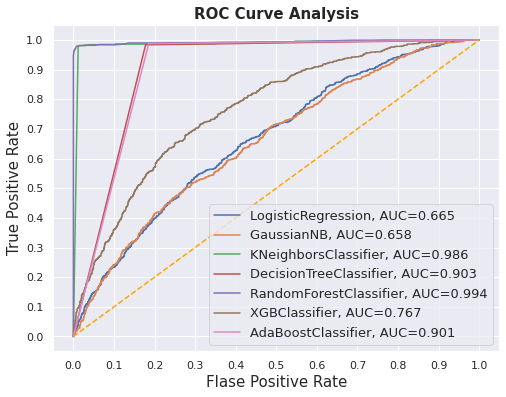

[array([0.6520269 , 0.66898422, 0.69829927, 0.70039252, 0.68016927,
       0.68876696, 0.64361774, 0.64626243, 0.65581828, 0.67813849]), array([0.63666335, 0.66402634, 0.69249118, 0.7002326 , 0.6645007 ,
       0.67968213, 0.63527746, 0.64508368, 0.6508255 , 0.68236963]), array([0.98096765, 0.98557422, 0.98674514, 0.99080248, 0.97311018,
       0.9825301 , 0.98561059, 0.98154984, 0.98623593, 0.97888306]), array([0.87952622, 0.89887673, 0.90169395, 0.89835966, 0.87974754,
       0.89503046, 0.88185649, 0.89298812, 0.8920324 , 0.89280804]), array([0.99113112, 0.98628353, 0.98906014, 0.99315517, 0.98594622,
       0.98525409, 0.99064143, 0.9923284 , 0.99042405, 0.99095196]), array([0.72799687, 0.76291275, 0.76384148, 0.79577437, 0.76573152,
       0.77993976, 0.75235177, 0.76211496, 0.74529079, 0.76963556]), array([0.89501295, 0.89561586, 0.91016852, 0.91306212, 0.88086361,
       0.87842013, 0.90115309, 0.88140917, 0.88183841, 0.88284019])]


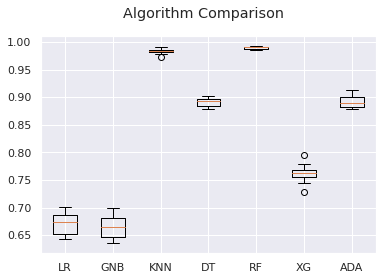

"\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.calibration import CalibratedClassifierCV\nfrom sklearn.model_selection import RandomizedSearchCV\n# Number of trees in random forest\nn_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]\n# Number of features to consider at every split\nmax_features = ['auto', 'sqrt']\n# Maximum number of levels in tree\nmax_depth = [int(x) for x in np.linspace(10, 110, num = 11)]\nmax_depth.append(None)\n# Minimum number of samples required to split a node\nmin_samples_split = [2, 5, 10]\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = [1, 2, 4]\n# Method of selecting samples for training each tree\nbootstrap = [True, False]\n# Create the random grid\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_sample

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score
from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.30,random_state=42,stratify=y)
classifiers = [LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 
               GaussianNB(), 
               KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='distance'), 
               DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
               RandomForestClassifier(random_state=1234),XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1),AdaBoostClassifier(algorithm='SAMME.R',base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,class_weight='balanced',
criterion='gini',max_depth=None,max_features='auto',max_leaf_nodes=None,min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0.0,presort='deprecated',
random_state=11,splitter='best'),learning_rate=1.0, n_estimators=2, random_state=None)] #SVC(gamma ='auto', probability = True)

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
from sklearn.metrics import average_precision_score
seed = 7
# Train the models and record the results
results=[]
for cls in classifiers:
    print(cls)
    #grid = GridSearchCV(estimator=cls, param_grid=dict(alpha=alphas))
    #grid.fit(Xtrain, ytrain)
    #print(grid)
    # summarize the results of the grid search
    #print(grid.best_score_)
    #print(grid.best_estimator_.alpha)
    model = cls.fit(Xtrain, ytrain)
    yproba = model.predict_proba(Xtest)[::,1]
    ypred = model.predict(Xtest)
    y_trainpred = model.predict(Xtrain)
    print("Precision: ",average_precision_score(ytest, ypred))
    fpr, tpr, _ = roc_curve(ytest,  yproba)
    auc = roc_auc_score(ytest, yproba)
    print("Train F1 Score: ", f1_score(ytrain,y_trainpred))
    print("Train Accuracy: ", accuracy_score(ytrain, y_trainpred))
    print("Test F1 Score: ", f1_score(ytest,ypred))
    print("Test Accuracy: ",accuracy_score(ytest, ypred))
    print("Validation F1 Score: ",cross_val_score(cls,Xtrain,ytrain,cv=5,scoring='f1_macro').mean())
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(cls,Xtrain,ytrain,cv=kfold,scoring='roc_auc')
    results.append(cv_results)
    print("Validation Accuracy: ",cross_val_score(cls,Xtrain,ytrain,cv=5,scoring='accuracy').mean())
    print("Confusion Matrix")
    print(confusion_matrix(ytest, ypred))
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()
print(results)
names=['LR','GNB','KNN','DT','RF','XG','ADA']
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
'''
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(Xtrain, ytrain)
print(rf_random.best_params_)'''


Ensemble Methods

In [39]:
from sklearn.ensemble import VotingClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.30,random_state=42,stratify=y)
estimator = [] 
estimator.append(('SVC', SVC(gamma ='auto', probability = True))) 
estimator.append(('RF',RandomForestClassifier(class_weight="balanced",n_estimators=100,max_depth=20)))
  
# Voting Classifier with hard voting 
vot_hard = VotingClassifier(estimators = estimator, voting ='hard') 
vot_hard.fit(Xtrain, ytrain) 
ypred = vot_hard.predict(Xtest) 
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, ypred))

score = accuracy_score(ytest, ypred) 
print("Hard Voting Score", score) 
print("Auc score: ",roc_auc_score(ytest, ypred))
# Voting Classifier with soft voting 
vot_soft = VotingClassifier(estimators = estimator, voting ='soft') 
vot_soft.fit(Xtrain, ytrain) 
ypred = vot_soft.predict(Xtest) 
score = accuracy_score(ytest, ypred) 
print("Soft Voting Score", score)
print("Auc score: ",roc_auc_score(ytest, ypred))

[[1872   77]
 [ 932 1016]]
Hard Voting Score 0.7410828842699513
Auc score:  0.741026567617996
Soft Voting Score 0.9132666153451373
Auc score:  0.9132830715061586


Neural Network

In [ ]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.30,random_state=42,stratify=y)
model = Sequential()


# input layer
model.add(Dense(400,  activation='relu'))
model.add(Dropout(0.2))



# hidden layer
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
history = model.fit(x=Xtrain, 
          y=ytrain, 
          epochs=500,
          batch_size=256,
          validation_data=(Xtest, ytest), 
          )

Epoch 1/500
36/36 [==============================] - 1s 14ms/step - loss: 0.6720 - val_loss: 0.6481
Epoch 2/500
36/36 [==============================] - 0s 10ms/step - loss: 0.6486 - val_loss: 0.6449
Epoch 3/500
36/36 [==============================] - 0s 10ms/step - loss: 0.6388 - val_loss: 0.6398
Epoch 4/500
36/36 [==============================] - 0s 10ms/step - loss: 0.6358 - val_loss: 0.6415
Epoch 5/500
36/36 [==============================] - 0s 10ms/step - loss: 0.6268 - val_loss: 0.6345
Epoch 6/500
36/36 [==============================] - 0s 10ms/step - loss: 0.6255 - val_loss: 0.6334
Epoch 7/500
36/36 [==============================] - 0s 10ms/step - loss: 0.6319 - val_loss: 0.6403
Epoch 8/500
36/36 [==============================] - 0s 11ms/step - loss: 0.6268 - val_loss: 0.6290
Epoch 9/500
36/36 [==============================] - 0s 10ms/step - loss: 0.6211 - val_loss: 0.6286
Epoch 10/500
36/36 [==============================] - 0s 10ms/step - loss: 0.6263 - val_loss: 0.6263

In [ ]:
predictions = model.predict_classes(Xtest)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
 accuracy_score(ytest, predictions)

0.9073646394662561

In [ ]:
confusion_matrix(ytest,predictions)

array([[1591,  358],
       [  40, 1908]])

In [ ]:
print(classification_report(ytest,predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.82      0.89      1949
         1.0       0.84      0.98      0.91      1948

    accuracy                           0.90      3897
   macro avg       0.91      0.90      0.90      3897
weighted avg       0.91      0.90      0.90      3897

